In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import tensorflow_hub as hub
import tensorflow_datasets as tfdata

In [2]:
# Define function to format images and return img and label
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


# Load datasets from tf datasets | cats vs dogs dataset
(raw_train, raw_validation, raw_test), metadata = tfdata.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# view data
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

# format loaded data and format images
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

23262
2


TensorShape([32, 224, 224, 3])

In [21]:
# Transfer learning, select mobilenet module
module_selection = ('mobilenet_v2', 224,1280)
handle_base, pixels , FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [22]:
# Create feature extractor operator and train model
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE +(3,), output_shape=[FV_SIZE],trainable=False)

print('Building Model with', MODULE_HANDLE)

model = Sequential([
    feature_extractor,
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
EPOCHS = 5

hist = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Building Model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 29s 37ms/step - loss: 0.0596 - accuracy: 0.9787 - val_loss: 0.0447 - val_accuracy: 0.9845
Epoch 2/5
582/582 [==============================] - 21s 33ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0386 - val_accuracy: 0.9867
Epoch 3/5
582/582 [==============================] - 21s 33ms/step - loss: 0.0269 - accuracy: 0.9904 - val_loss: 0.0374 - val_acc

In [36]:
# Save model
CATS_VS_DOGS_SAVED_MODEL = 'exp_saved_model'
tf.saved_model.save(model,CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model\assets


INFO:tensorflow:Assets written to: exp_saved_model\assets


In [37]:
# convert to tf lite model
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

tflite_model = converter.convert()
tflite_model_file = pathlib.Path('tf_model_cats.tflite')
tflite_model_file.write_bytes(tflite_model)

8877536

In [4]:
# Inference
from tqdm import tqdm
import time
# Load tflite model and assign tensors
tflite_model_file = 'tf_model_cats.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

predictions = []

# Show how many predictions per second | each iteration is 1000 predictions
test_labels, test_imgs = [],[]
num_samples = 1000
for img, label in tqdm(test_batches.take(num_samples)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# Show how many are correct 
start_timer = time.time()
score = 0 
for item in range(0,len(predictions)):
    predict = np.argmax(predictions[item])
    label = test_labels[item]

    if predict == label:
        score = score+1

print('out of {} samples, {} are correct. Time (s): {}'.format(num_samples, score, time.time()-start_timer ))

100%|██████████| 1000/1000 [00:13<00:00, 75.51it/s]

out of 1000 samples, 993 are correct. Time (s): 0.0030412673950195312


In [6]:
# Plotting function
class_names = ['cat', 'dog']

def plot_img(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)
    plt.imshow(img, cmap=plt.cm.binary)

    predcited = np.argmax(predictions_array)

    if predcited == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predcited],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)
    return color

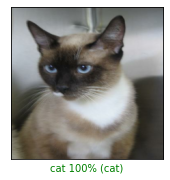

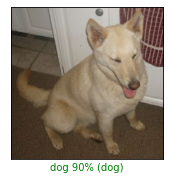

In [8]:
# Visualize results
max_index = 2
for index in range(0,max_index):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    
    predcited_result = np.argmax(predictions[index])

    plot_img(index,predictions, test_labels, test_imgs)
    plt.show()



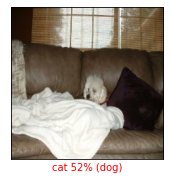

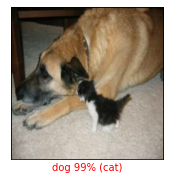

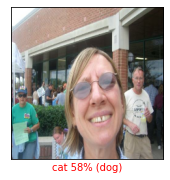

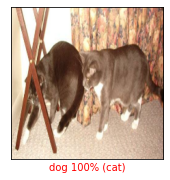

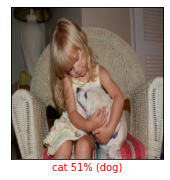

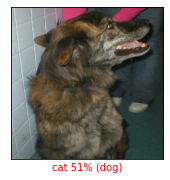

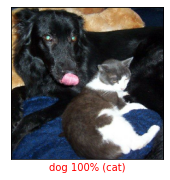

In [9]:
# Visualize only if there is an error
# Show the inaccurate results only | for debugging 
max_index = 1000
for index in range(0,max_index):
    
    
    predcited_result = np.argmax(predictions[index])

    if predcited_result == test_labels[index]:
        color = 'green'
    else:
        color = 'red'

    if color == 'red':
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)

        plot_img(index,predictions, test_labels, test_imgs)
        plt.show()
        
    else:
        pass